# How to remove common systematics from Kepler, K2 and TESS light curves using the `CBVCorrector`?

Cotrending Basis Vectors (CBVs) are generated in the PDC component of the pipeline and are used to remove systematic trends in light curves. They are built from the most common systematic trends observed in each PDC Unit of Work (Quarter for Kepler, Campaign for K2 and Sector for TESS). Each Kepler and K2 module output and each CCD in K2 has its own set of CBVs. You can read an introduction to the CBVs in [Demystifying Kepler Data](https://arxiv.org/pdf/1207.3093.pdf) or to an even greater detail in the [Kepler Data Processing Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19081-003-KDPH.pdf). The same basic method is used for all three missions.

This tutorial provides examples of how to utilize the various CBVs to clean lightcurves of common trends experienced by all targets. The techniques exploit two goodness metrics that characterize the performance of the fit. CBVCorrector is based on the RegressionCorrector class in LightKurve, if you are not yet familiar with that method then it is recommended you read the tutorial first.

## Cotrending Basis Vector Types

There are three basis types of CBVs: 
- **Single-Scale** contains all systematic trends combined is a single set of basis vectors. 
- **Multi-Scale** contains systematic trends in specific wavelet band passes, There are ussuall three sets of multi-scale basis vectors.
- **Spike** contains only short impulsive spike systematics.

There are two different corrections in PDC: Single-Scale and Multi-Scale. Single-Scale performs the correction in a single bandpass. Multi-Scale performs the correction in three separate wavelet-based bandpasses. Both corrections are performed in PDC but we can only export a single PDC light curve. So, PDC must choose which of the two on a per-target basis. Generally speaking, single-scale performs better as preserving longer period signals. But at periods close to transiting planet durations multi-scale performs better at preserving signals. So, PDC mostly chooses multi-scale for use within the planet finging pipeline and for archive. You can find in the light curve FITS header which PDC method was chosen (keyword “PDCMETHOD” <font color=red>**Confirm the name!!!**</font>). FVor your individual research needs, the mission supplied lightcurves might not be ideal and so the CBVs are provided to the user to perform their own correction.

## Obtaining the CBVs

When generating a CBVCorrector object the appropriate CBVs are automatically downloaded from MAST. Lets generate this object for a particularily interesting TESS variable target. We first download the lightcurve file.

In [1]:
from lightkurve import search_lightcurvefile
import numpy as np
import matplotlib.pyplot as plt
lcf = search_lightcurvefile('TIC 99180739', mission='tess', sector=10).download()

Next, we create a CBVCorrector object. This will download the CBVs appropriate for this target. In the case of TESS, this means, the CBVs associated with the CCD this target is on and for Sector 10 (as we specified above).

In [2]:
from lightkurve.correctors import CBVCorrector
cbvCorrector =  CBVCorrector(lcf.SAP_FLUX)

Let's look at the CBVs downloaded.

In [3]:
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType.Band: MultiScale.3, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 10.1.1, CBVType : Spike, nCBVS : 6]

We see that there are a total of 5 sets of CBVs, all associated with TESS Sector 10, Camera 3 and CCD 3. The number of CBVs per type is also given. Let's plot the Single-Scale CBVs, which contain all systematics combined.

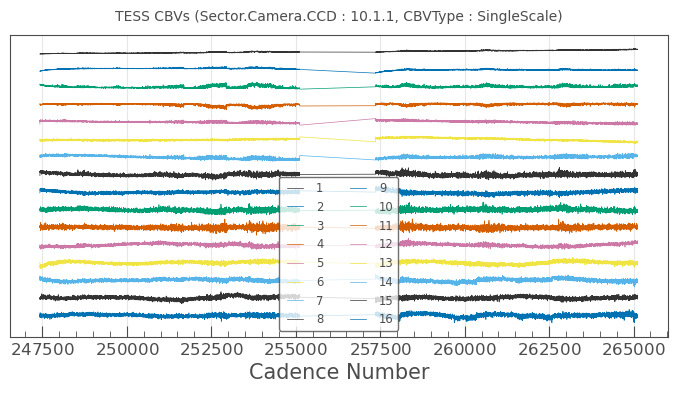

In [4]:
cbvCorrector.cbvs[0].plot_cbvs();

The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs.

## Example Simple Correction with CBVCorrector by Inhibiting Over-Fitting

There are three basic correction methods within CBVCorrector:
- **correct_gaussian_prior**: Performs the correction using LightKurve RegressionCorrector methods by adjusting the L2-Norm (Ridge Regression) regularization penalty term
- **correct_ElasticNet**:  Performs the correction using Scikit-Learn's [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which combines both a L1- and L2-Norm regularization.
- **correct_optimizer**: Performs the correction by optimizing the L2-Norm regularization penalty term using the goodness metrics as the loss function.

If you are unfamilar with L2-Norm regularization and how it relates to a Gaussian prior in a linear design matrix then [this is a good reference](https://katbailey.github.io/post/from-both-sides-now-the-math-of-linear-regression/) <font color=red>**Perhaps get a more definitive reference?**</font>)

We'll start with correct_gaussian_prior by using a very weak regularization term (alpha=1e-4).

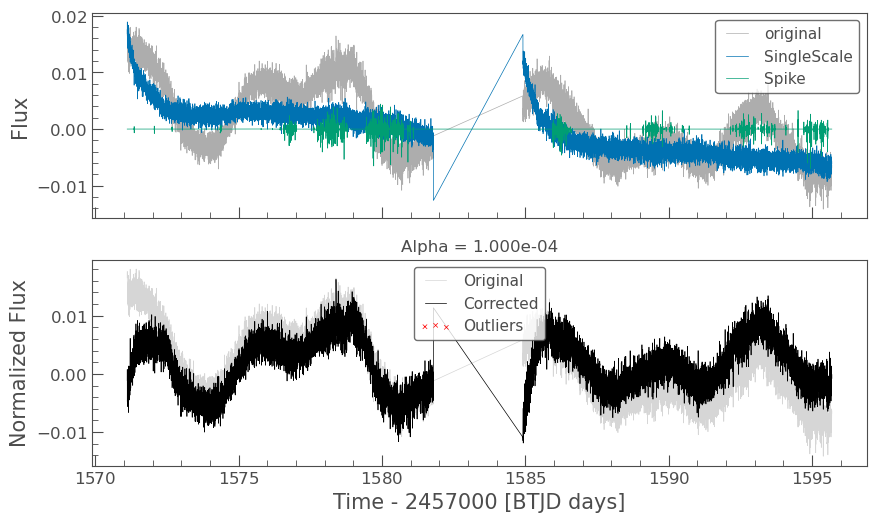

In [5]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale', 'Spike']
# Select which CBV indices to use
cbv_indices = [np.arange(1,9), 'ALL']
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices,alpha=1e-4)
cbvCorrector.diagnose();

At first sight, this looks like a good correction. Both the Single-Scale and Spike basis vectors are being utilized to fit out as much of the signal as possible. The corrected light curve is indeed flatter. But this was essentially an unrestricted least-squares correction and we may have _over-fitted_. The very strong lips right at the beginning of each orbit is probably a chance correlation between the star's inherent stellar variability and the thermal settling systematic that is common in Kepler and TESS lightcurves. Let's look at the CBVCorrector goodness metrics to determine if this is the case.

In [6]:
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

Over fitting Metric: 0.7136472577946986
Found 34 neighboring targets for under-fitting metric
Downloading... this might take a while
Neighboring targets ready for use
Under fitting Metric: 0.9197534157230162


The first time you run the under-fitting goodness metric it will download targets in the neighborhood around the target under study in order to estimate the residual systematics (they are stored for subsequent compuations). A goodness metric of 0.8 or above is generally considered good. In this case, it looks like we over-fitted (over-fitting metric = 0.71). Even though the corrected light curve looks better, our metric is telling us we probably injected signals into our lightcurve and we should not trust this really nice looking curve. Maybe we can do better if we _regularize_ the fit.

## Using the Goodness Metrics to optimize the fit

We will start by performing a scan of the over- and under-fit goodness metrics as a function of the L2-Norm regularization term, alpha.

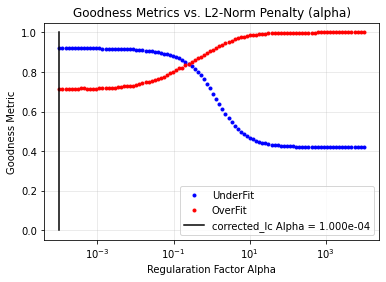

In [7]:
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

This scan also plots the last used alpha parameter as a vertical black line (alpha=1e-4 in our case). We are clearly not optimizing this fit for both over- and under-fitting. Let's use correct_optimizer to try to optimize the fit.

Optimized Over-fitting metric: 0.8270844593519324
Optimized Under-fitting metric: 0.8599825691970151
Optimized Alpha: 1.752e-01


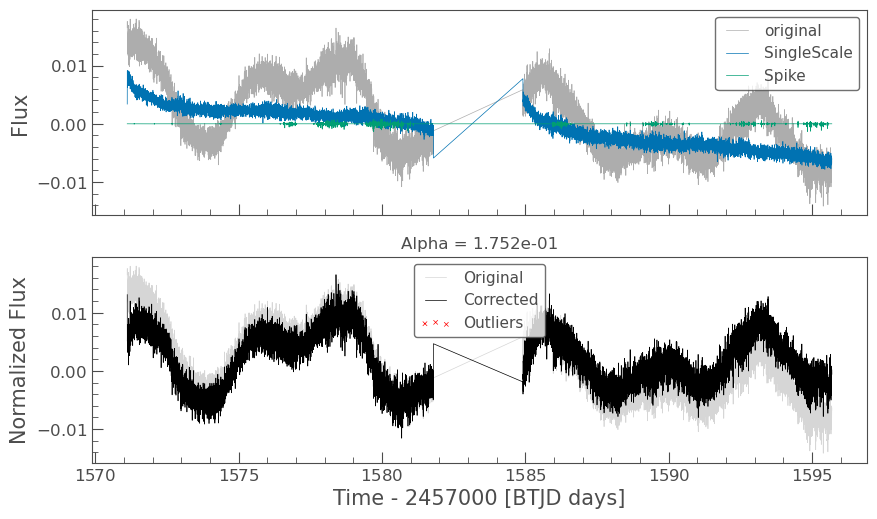

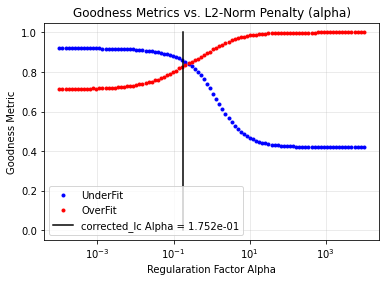

In [8]:
cbvCorrector.correct_optimizer(cbv_type=cbv_type, cbv_indices=cbv_indices);
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Much better! We see the thermal settling systematic is still being removed, but the stellar variabity is better preserved. If we want to tune the fit event more, by perhaps ensuring we are not over-fitting at all, then we can set the target over and under scores.

Optimized Over-fitting metric: 0.8996061394925209
Optimized Under-fitting metric: 0.7280858345778362
Optimized Alpha: 8.359e-01


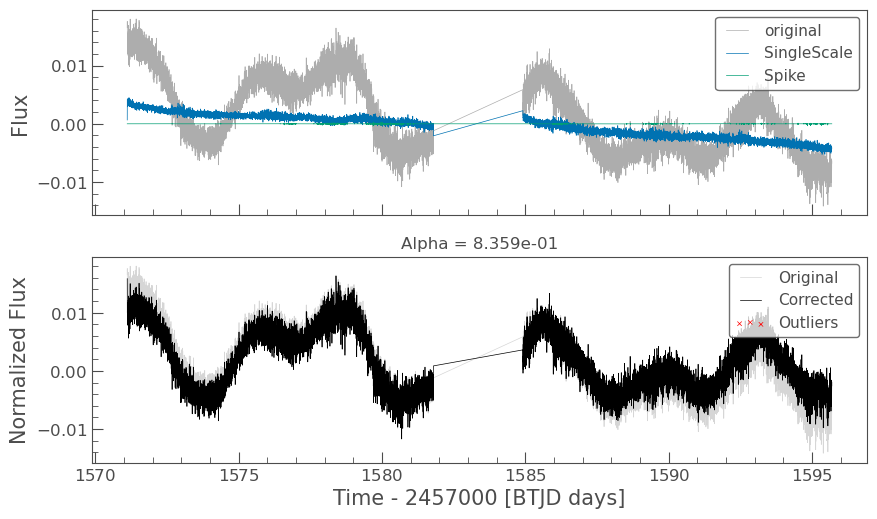

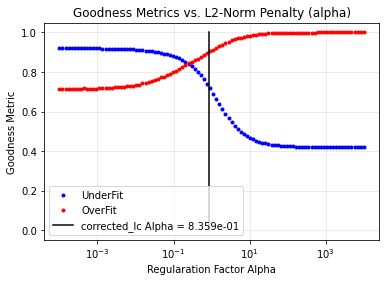

In [9]:
cbvCorrector.correct_optimizer(cbv_type=cbv_type, cbv_indices=cbv_indices, 
                              target_over_score=0.9, target_under_score=0.5)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

We are now perhaps biasing too far towards under-fitting. But depending on your research interests, this might be best.

## No Single Best Answer Example

Let's now look at another example, this time where there is no clear single best answer. Again, we will use the Single-Scale and Spike basis vectors for the correction and begin with low regularization.

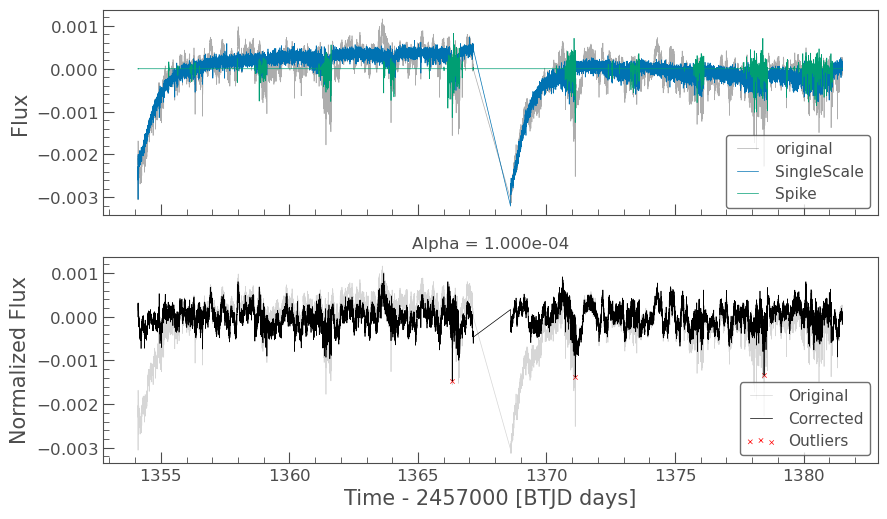

In [10]:
lcf = search_lightcurvefile('TIC 38574307', mission='tess', sector=2).download()
cbvCorrector =  CBVCorrector(lcf.SAP_FLUX)
cbv_type = ['SingleScale', 'Spike']
cbv_indices = [np.arange(1,9), 'ALL']
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices,alpha=1e-4)
cbvCorrector.diagnose();

At first sight, this looks pretty good. The long term trends have been removed and the noisy bits have been removed with the spike basis vectors. But did we really do a good job?

Over fitting Metric: 0.22426279488636372
Found 50 neighboring targets for under-fitting metric
Downloading... this might take a while
Neighboring targets ready for use
Under fitting Metric: 0.9869701257779175


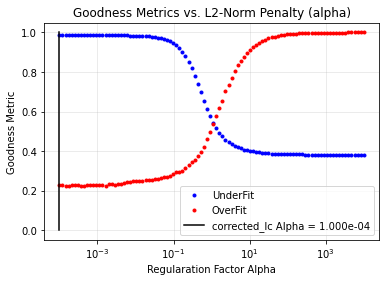

In [11]:
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Hmm... The over-fitting goodness metric says we are severely over-fitting. Not only that, there appears to not be an Alpha parameter that brings both goodness metrics above 0.8. What's going on here? Let's zoom in on the correction.

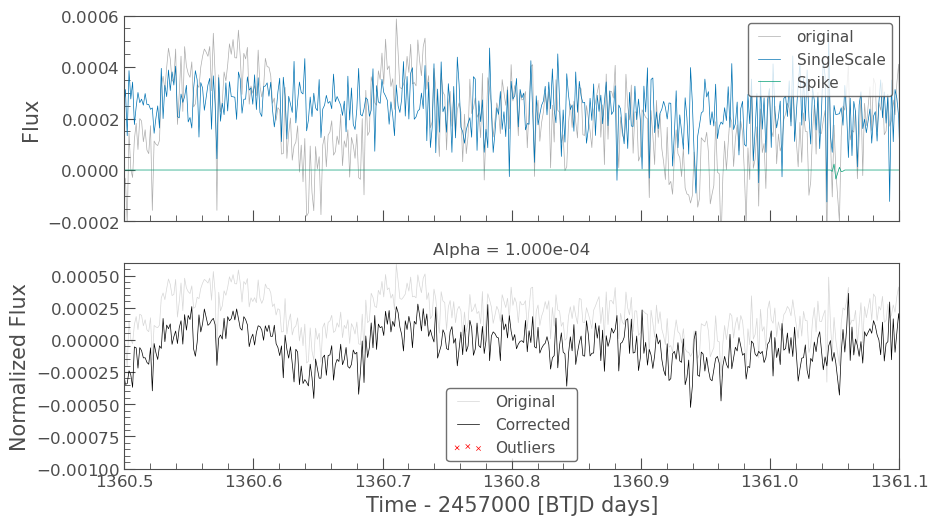

In [12]:
pltAxis = cbvCorrector.diagnose()
pltAxis[0].set_xlim(1360.5, 1361.1)
pltAxis[0].set_ylim(-0.0002, 0.0006);
pltAxis[1].set_xlim(1360.5, 1361.1)
pltAxis[1].set_ylim(-0.001, 0.0006);

We see that the correction is injecting high frequency noise at comperable amplitude to the original signal. We have indeed over-fitted! The goodness metrics perform a _broadband_ analysis of over- and under-fitting. Even though our eyes did not see the high frequency noise injection, the goodness metrics did! So, what should we do? It depends on what you are trying to investigate. If you are only looking at the low frequency signals in the data then perhaps you don't care about the high frequency noise injection. If you really do care about the high frequency signals then you should increase the Alpha parameter, or set the target goodness scores as we do below. 

Optimized Over-fitting metric: 0.7998086520806775
Optimized Under-fitting metric: 0.42935181007690726
Optimized Alpha: 3.915e+00


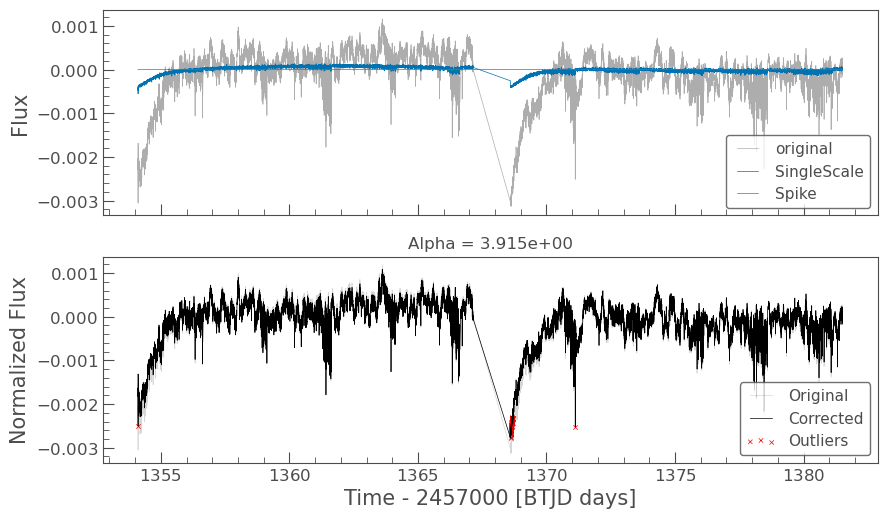

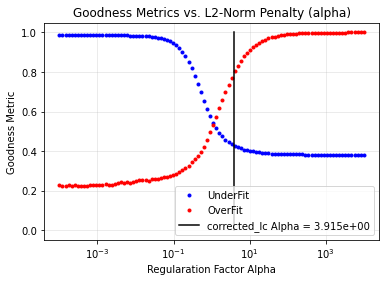

In [13]:
cbvCorrector.correct_optimizer(cbv_type=cbv_type, cbv_indices=cbv_indices, 
                              target_over_score=0.8, target_under_score=0.5)
cbvCorrector.diagnose()
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

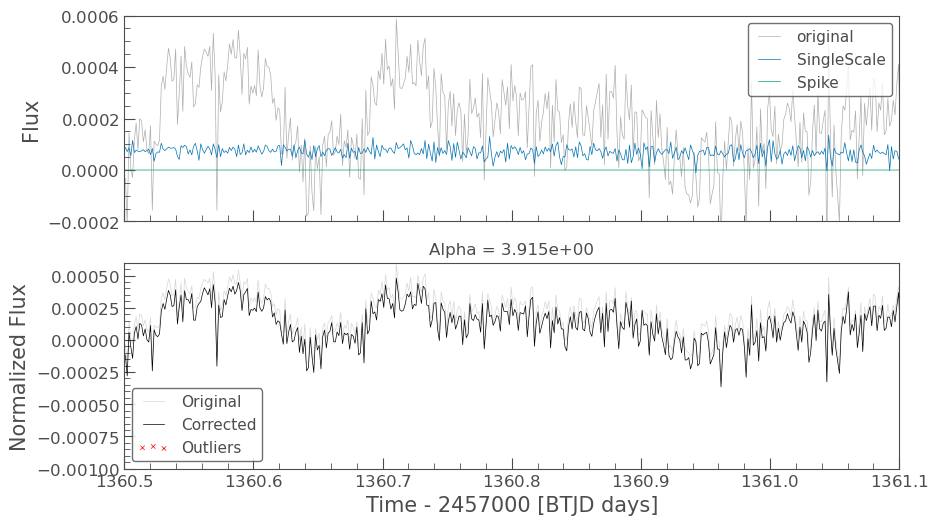

In [14]:
# Again zoom in to see the detail
pltAxis = cbvCorrector.diagnose()
pltAxis[0].set_xlim(1360.5, 1361.1)
pltAxis[0].set_ylim(-0.0002, 0.0006);
pltAxis[1].set_xlim(1360.5, 1361.1)
pltAxis[1].set_ylim(-0.001, 0.0006);

We see now, the high frequency noise injection is small compared to the original amplitudes in the lightkurve. We didn't fully remove the systematics and are now under-fitting, but perhaps that's the best we can do.

### ...Or can we still do better?

Perhaps we are using the incorrect CBVs for this target. Below is a tuned multi-step fit where we first fit the multi-scale Band 2 CBVS then the Spike CBVs. The multi-scale band 2 CBVs contains intermediate frequency systematic signals. They should not injected high frequency noise. We also utilize the correct_ElasticNet corrector, which allows us to add in a L1-Norm term (Lasso Regularization), L2-Norm helps snap some bases vector fit coeficients to zero and can results in more stable, less noisy fits. The result is a much better compromise between over- and under-fitting. The spikes are not well removed but increasing the weight on the spike removal results in over-fitting. We can also try the multi-scale band 3 CBVs, whcih contain high frequency systematics, but the over-fitting metric indicates using them results in even greater over-fitting. Perhaps more tuning and optimization could get us even closer to an ideal fit.

Over fitting Metric: 0.6645450665520086
Under fitting Metric: 0.775170762257274


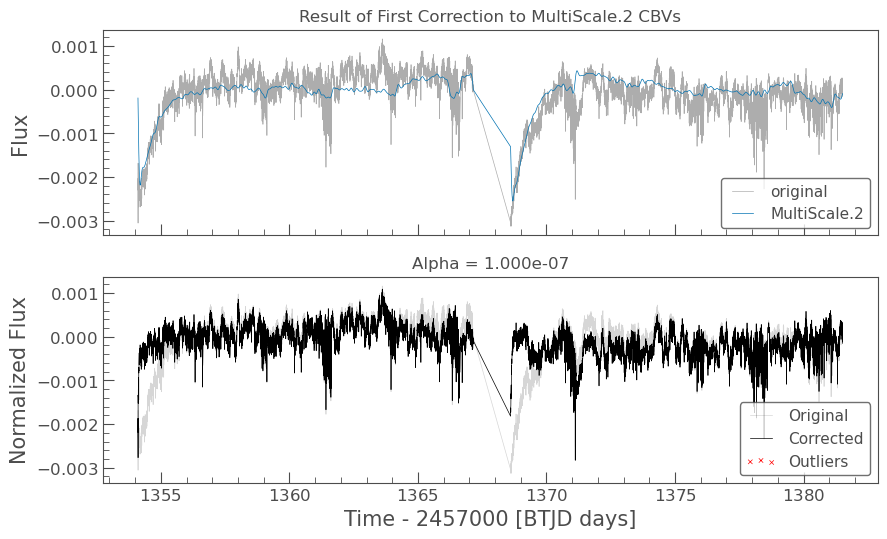

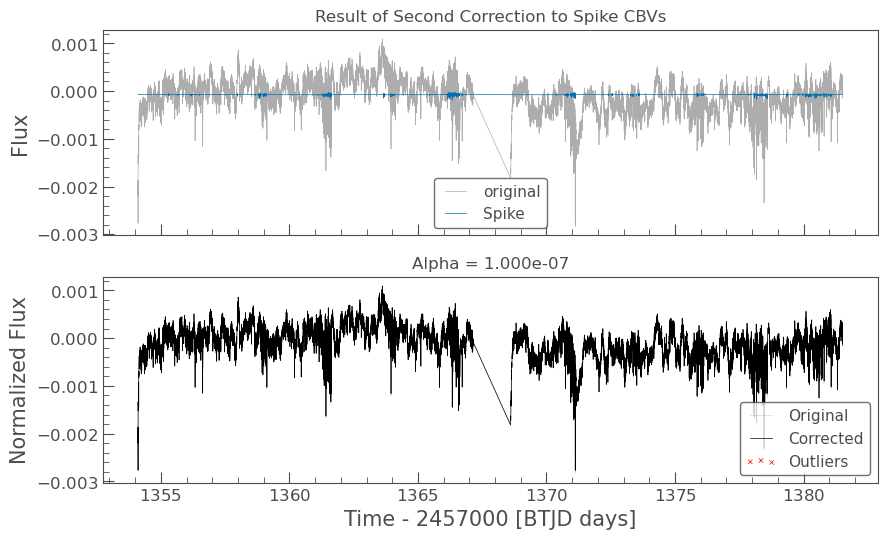

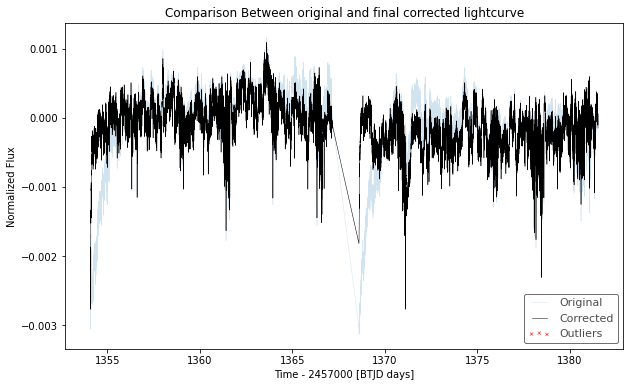

In [15]:
# Fit to the Multi-Scale Band 2 CBVs with ElasticNet to add in a L1-Norm (Lasso) term
cbvCorrector.correct_ElasticNet(cbv_type=['MultiScale.2'], cbv_indices=[np.arange(1,9)], alpha=1.0e-7, l1_ratio=0.5)
ax = cbvCorrector.diagnose()
ax[0].set_title('Result of First Correction to MultiScale.2 CBVs');
# Set the corrected LC as the initial LC in a new CBVCorrector object before moving to the next correction.
# You could just reassign to the first cbvCorrector object, if you do not wish to save it.
cbvCorrectorIter2 = cbvCorrector.copy()
cbvCorrectorIter2.lc = cbvCorrectorIter2.corrected_lc

# Fit to the Spike Basis Vectors, again with using a L1-Norm term.
cbvCorrectorIter2.correct_ElasticNet(cbv_type=['Spike'], cbv_indices=['ALL'], alpha=1.0e-7, l1_ratio=0.7)
ax = cbvCorrectorIter2.diagnose()
ax[0].set_title('Result of Second Correction to Spike CBVs');

# Compute the final goodness metrics compared to the original lightcurve.
cbvCorrectorIter2.lc = cbvCorrector.lc
#cbvCorrectorPrime.diagnose()
print('Over fitting Metric: {}'.format(cbvCorrectorIter2.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrectorIter2.under_fitting_metric()))

# Plot the final correction
_, ax = plt.subplots(1, figsize=(10, 6))
cbvCorrectorIter2.lc.plot(ax=ax, normalize=False, alpha=0.2, label='Original')
cbvCorrectorIter2.corrected_lc[~cbvCorrectorIter2.cadence_mask].scatter(
                                            normalize=False, c='r', marker='x',
                                            s=10, label='Outliers', ax=ax)
cbvCorrectorIter2.corrected_lc.plot(normalize=False, label='Corrected', ax=ax, c='k')
ax.set_title('Comparison Between original and final corrected lightcurve');

So, which CBVs are best to use? There is no one single answer, but generally speaking, the Multi-Scale Basis vectors are more versitile, but there are also more of them, which means more degrees of freedom in your fit. More degrees of freedom can result in more over-fitting without proper regularization. It is recommened the user try different combinations of CBVs and use objective metrics to decide which fit is the best.

# A couple final comments on CBVCorrector

### Application to Kepler vs K2 vs TESS

CBVCorrector works accross Kepler, K2 and TESS. However the Multi-Scale and Spike basis vectors are only available for TESS[<sup>1</sup>](#fn1). 

If you want to just get the CBVs but not generate a CBVCorrector object then use the functions _get_kepler_cbvs_ and _get_tess_cbvs_ within the cbvcorrector module.

<sup>1</sup><span id="fn1"> Unfortunately, the Multi-Scale and Spike CBVs are not even archived at MAST for Kepler/K2.</span>

### Units

The CBVCorrector stores the lightcurves as zero-centered median normalized. This allows for much more convenient application of corrections. If you wish to return the unnormalized flux in units of electrons per second then there is a method to do so:

In [16]:
# This is unitless
cbvCorrector.lc.flux_unit

Unit(dimensionless)

In [17]:
# This has units of electrons per second
cbvCorrector.denormalized_lc.flux_unit

Unit("electron / s")

In [18]:
# This is unitless
cbvCorrector.corrected_lc.flux_unit

Unit(dimensionless)

In [19]:
# This has units of electrons per second
cbvCorrector.denormalized_corrected_lc.flux_unit

Unit("electron / s")